# A few general stats of interest for CIS-CNRS work on open science platforms

## Summary

- [Platform by platform description](#platform-by-platform-description)
  - [HAL](#hal)
  - [OpenEdition](#openedition)
  - [RechercheDataGouv](#recherchedatagouv)
- [Code](#code)
  - [Librairies](#librairies)
  - [Functions](#functions)
  - [Data extractions](#data-extraction)
      1. [HAL](#overall-hal-stats)
         1. [Number of deposits by docType and by year](#deposit-doctype-year)
         2. [Classifications of disciplines, domains & subdomains](#hal-domains)
         3. [Typology and repartitions of the CC licences of HAL ressources](#hal-licencing)  
      2. [OpenEdition]
      3. [RechercheDataGouv]
  - [Stored Jsons](/jsons)
    - [HAL resources by type and by year](/HAL_ressources_bytype_byyear.json)
    - [HAL domain typology](/HAL_domains.json)

---

## Platform by platform description 

### HAL
- HAL has a public API allowing a good characterization of its hosted ressources
- All information about HAL  : [https://api.archives-ouvertes.fr/docs/search](https://api.archives-ouvertes.fr/docs/search)
- The API works with Apache SolR syntax. Detailed instructions are [here](https://cwiki.apache.org/confluence/display/solr/Common+Query+Parameters)
- A full list of fields to look though all HAL ressources is available here (see below for detailed quiery syntax): https://api.archives-ouvertes.fr/docs/search/?schema=fields#fields

#### HAL Ressources
Breakdown of the request : "http://api.archives-ouvertes.fr/search/?q=*:*&rows=0&wt=json&indent=true&facet=true&facet.pivot=docType_s&facet.sort=count"
- `http://api.archives-ouvertes.fr/search/` -> the API URL. Note that some specific HAL repositories ("référentiels") can be quieried by using this adress : https://api.archives-ouvertes.fr/docs/ref, for instance the review repository : https://api.archives-ouvertes.fr/docs/ref/resource/journal
- `q=*:*` -> on the right of the double dot is the string to search, on the left the field. For instance `title_t:japon` means that I am looking for the string <em>japon</em> in the field `titre_t`. If the field name is unspecified, the search will be on the text index by default.
- `&` is used to separate different additional parameters
- `rows=0` allows retrieving solely the numbers of results and removing the documents from the response body, helpful for stats. By default, requests only allow for a max. number of 30 results
- `wt=json&indent=true` returns an indented json format
- `facet=true&facet.pivot=docType_s` facets give a distinct list of values for a given field. Here we activate the facets and use the `docType_s` field as a facet
- `facet.sort=count` we ask for a count the total items in each docType


## Code 

#### Librairies

In [ ]:
import matplotlib.pyplot as plt
import requests, json
import pandas as pd
from pprint import pprint

#### Functions

In [186]:
## Adding a simple function to pass a URL and return whole json file + the list of dictionnaries contained in docType. 
def jsonify(quieryURL):
    response = requests.get(quieryURL).json()
    return response

#### Data extractions

##### Overall HAL stats

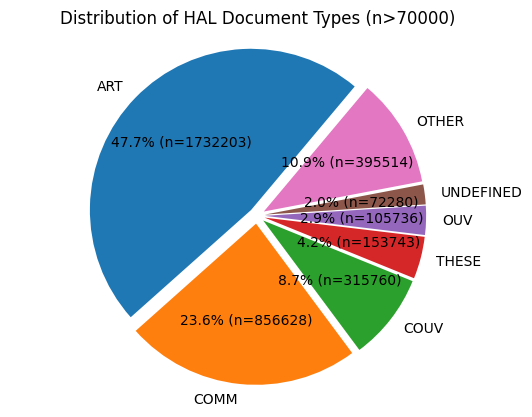

In [187]:
URL = "http://api.archives-ouvertes.fr/search/?q=*:*&rows=0&wt=json&indent=true&facet=true&facet.pivot=docType_s&facet.sort=count"

response = jsonify(URL)

# Extracting a list of dictionnaries with each type of documents and the total amount
data = (response["facet_counts"]["facet_pivot"]["docType_s"])

# Spliting in two lists of dictionnaries, one with docTypes having more than 70k items, one with less than 70k items
dataHigh = [e for e in data if int(e['count']) > 70000]
dataLow = [e for e in data if int(e['count']) < 70000]

# Appending the dictionnary containing docTypes > 70k items with a single entry "OTHER" of the sum of all other resources items
dictLow = {'count' : sum([e['count'] for e in dataLow]), 'value' : 'OTHER'}
dataHigh.append(dictLow)

# Extract labels and values
labels = [item['value'] for item in dataHigh]
values = [item['count'] for item in dataHigh]
explode = [0.05 for _ in range(len(values))] # for better clarity

# Create a pie chart displaying both percentage and absolute value
plt.pie(values, explode = explode, labels=labels, autopct=lambda pct: f"{pct:.1f}% (n={int(pct/100.*sum(values))})", startangle=50)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of HAL Document Types (n>70000)')
plt.show()


##### Number of deposits by docType and by year

Now lets see in detail the progression over the years of each docType deposit

In [411]:
# I'm extracting the list of docTypes in order to iter over it
#types = [e['value'] for e in data]

# I store it in a file to spare the API
# with open ('docTypes.txt', 'w') as fichierDocTypes:
#     for e in types:
#         fichierDocTypes.write(f"'{e}',")

with open ('docTypes.txt', 'r') as fichierDocTypes:
    types = eval(str([e for e in fichierDocTypes.readlines()]).replace('"',""))

# I create a dictionnary wich contains the docType as a key and as a value the URL to get its yearly deposits starting from 1998 (values == 0 before)
liURL = {e : f"https://api.archives-ouvertes.fr/search/?q=docType_s:{e}"
         f"&rows=0&wt=json&indent=true&facet=true&facet.range=submittedDateY_i&facet.range.start=1998"
         f"&facet.range.end=2025&facet.range.gap=1" for e in types}

# I create another dictionary. It takes a while (~35sec) so I'll store it in a resut_dict.json file. This dictionnary contains :
# - as a key : the resource type
# - as a value a nested dictionnary containing :
#   - as a key : years
#   - as a value : # of deposits
                     
# result_dict = {}
# for e, f in liURL.items():
#     response = jsonify(f)
#     # getting one out of two elements starting from even rank (i.e. year)
#     years = response["facet_counts"]["facet_ranges"]["submittedDateY_i"]["counts"][::2]
#     # getting one out of two elements starting from uneven rank (i.e. # of deposits)
#     counts = response["facet_counts"]["facet_ranges"]["submittedDateY_i"]["counts"][1::2]
#     result_dict[e] = {year: count for year, count in zip(years, counts)}
# with open('result_dict3.json', 'w') as json_file:
#    json.dump(result_dict, json_file)

# loading a dictionnary containing # of deposits x years x docType
with open('result_dict3.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

df = pd.DataFrame.from_dict(loaded_dict, orient='index')

df2 = pd.DataFrame.from_dict(loaded_dict, orient='index')
df2.loc['Total'] = df.sum(axis=0)
df2['Total'] = df.sum(axis=1)

display(df2)#.sort_values(by='Total', ascending=False))

['ART', 'COMM', 'COUV', 'THESE', 'OUV', 'UNDEFINED', 'MEM', 'OTHER', 'REPORT', 'IMG', 'POSTER', 'ISSUE', 'NOTICE', 'PROCEEDINGS', 'BLOG', 'HDR', 'PATENT', 'REPORT_LABO', 'VIDEO', 'LECTURE', 'REPORT_MAST', 'REPORT_LPRO', 'REPORT_LICE', 'TRAD', 'SOFTWARE', 'PRESCONF', 'CREPORT', 'REPORT_DOCT', 'REPORT_ETAB', 'MAP', 'SON', 'REPORT_FORM', 'REPORT_GMAST', 'OTHERREPORT', 'NOTE', 'SYNTHESE', 'REPORT_FPROJ', 'REPORT_GLICE', 'REPACT', 'ETABTHESE', 'MEMLIC', 'REPORT_RFOINT', 'REPORT_COOR', 'REPORT_RETABINT', 'MANUAL']


1998  1999  2000  2001  2002  2003  2004   2005   2006  \
ART               359  2787  5883  2026   639   789  1717   8074  23125   
COMM               98  1453  2206  1515   602   836  1076   5655  17041   
COUV                1    34    63    28    86    61    87    971   3543   
THESE              35   217   524   428   381   618  1509   1516   1996   
OUV                 1     5     5     5     5     6    16    493   1490   
UNDEFINED           2     7     7    11    33   221   621   1180   1693   
MEM                 0     6     0    10     0    26    39     15     35   
OTHER               0     0     0     0    30    34    59    296   1590   
REPORT             23   134   135    95    84   107    82    159   7099   
IMG                 0     0     0     0     0     0     0      0      0   
POSTER              0     0     0     0     1     1     0     30    105   
ISSUE               0     0     0     0     0     0     0      7     28   
NOTICE              0     0     0     0     0     0     0      0      7   
PROCEEDINGS         0     0     0     0     0     0     2     16     33   
BLOG                0     0     0     0     0     0     0      0      0   
HDR                 0     2    11     8    16    21    62     53    113   
PATENT              0     0     0     0     0     0     0     29    140   
REPORT_LABO         0     0     0     0     0     0     0      0      0   
VIDEO               0     0     0     0     0     0     0      0      0   
LECTURE             2     3     1    22     8     0     2      5     95   
REPORT_MAST         0     0     0     0     0     0     0      0      0   
REPORT_LPRO         0     0     0     0     0     0     0      0      0   
REPORT_LICE         0     0     0     0     0     0     0      0      0   
TRAD                0     0     0     0     0     0     0      0      0   
SOFTWARE            0     0     0     0     0     0     0      0      0   
PRESCONF            0     0     0     0     0     0     0      0      0   
CREPORT             0     0     0     0     0     0     0      0      0   
REPORT_DOCT         0     0     0     0     0     0     0      0      0   
REPORT_ETAB         0     0     0     0     0     0     0      0      0   
MAP                 0     0     0     0     0     0     0      0      0   
SON                 0     0     0     0     0     0     0      0      0   
REPORT_FORM         0     0     0     0     0     0     0      0      0   
REPORT_GMAST        0     0     0     0     0     0     0      0      0   
OTHERREPORT         0     0     0     0     0     0     0      0      0   
NOTE                0     0     0     0     0     0     0      0      0   
SYNTHESE            0     0     0     0     0     0     0      0      0   
REPORT_FPROJ        0     0     0     0     0     0     0      0      0   
REPORT_GLICE        0     0     0     0     0     0     0      0      0   
REPACT              0     0     0     0     0     0     0      0      0   
ETABTHESE           0     0     0     0     0     0     0      0      0   
MEMLIC              0     0     0     0     0     0     0      0      0   
REPORT_RFOINT       0     0     0     0     0     0     0      0      0   
REPORT_COOR         0     0     0     0     0     0     0      0      0   
REPORT_RETABINT     0     0     0     0     0     0     0      0      0   
MANUAL              0     0     0     0     0     0     0      0      0   
Total             521  4648  8835  4148  1885  2720  5272  18499  58133   

                  2007  ...    2016    2017    2018    2019    2020    2021  \
ART              30366  ...   56729   87569  100335  193624  291776  168731   
COMM             21402  ...   40268   50366   53131   73164  141418   58346   
COUV              4972  ...   10729   20589   20578   27779   47094   38144   
THESE             2780  ...    7496    8958   18992   10652   16739   10602   
OUV               1842  ...    4016    7564    6438    8723   17092   11351   
UNDEFINED        

Now i'll try to generate a nice Stackplot for us to have a good overview 

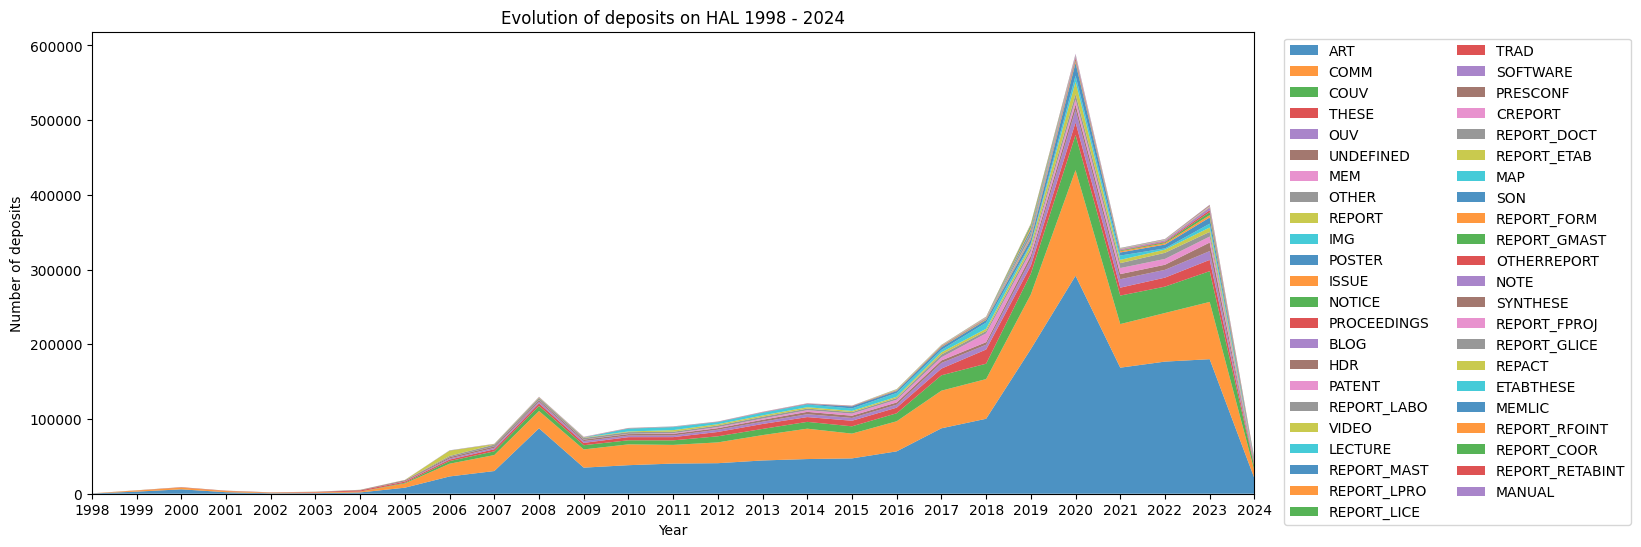

In [455]:
tableContent = {key: list(value.values()) for key, value in loaded_dict.items()}
year = df.columns.tolist()
resourcesDeposit = tableContent

fig, ax = plt.subplots(figsize=(15,6))
ax.stackplot(year, resourcesDeposit.values(),
             labels=population_by_continent.keys(), alpha=0.8)
ax.legend(loc='upper right', ncol =2, reverse=False, bbox_to_anchor=(1.33, 1.0))
ax.set_title('Evolution of deposits on HAL 1998 - 2024')
ax.set_xlabel('Year')
ax.set_xlim(0,26)
ax.set_ylabel('Number of deposits')

plt.show()

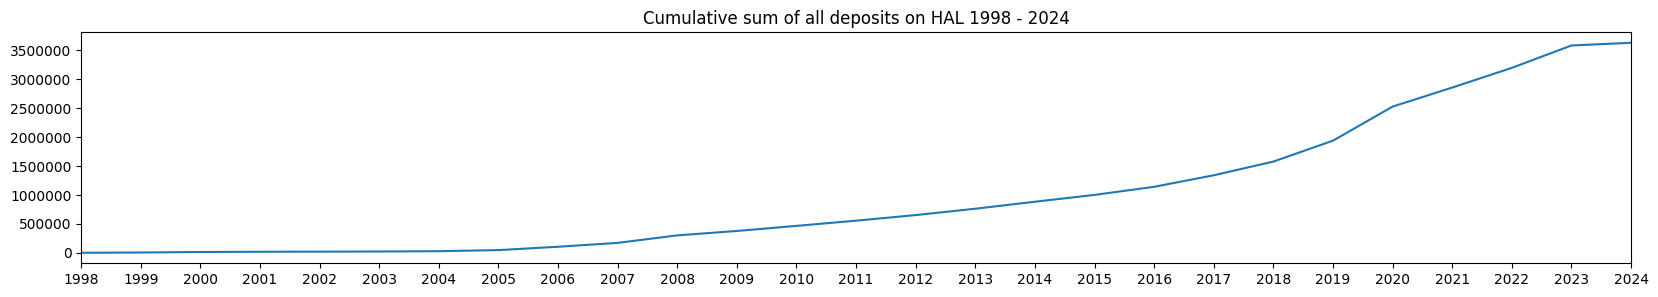

In [461]:
x = np.cumsum(df.sum(axis=0).tolist())
y = df.columns.tolist()
plt.figure(figsize=(20,3))
plt.title('Cumulative sum of all deposits on HAL 1998 - 2024')
plt.plot(y,x)
plt.xlim(0,26)
plt.ticklabel_format(axis='y', style='plain')


### A first characterization of HAL deposits by domain

HAL domains field is multivalued, one document can be in several domains at the same time, that's why I did an histogram. Domain format is of two types : "domain" or "domain.subdomain". However, some articles are coded only in "domain" form, some other only in "domain.subdomain" form, and other ones in both. I tested and for instance the value for shs is not equal to the sum of the value of all shs subdomains. "shs" should be considered as a subdomain per se and included in total of all values corresponding to keys containing "shs*".  

{'chim': 60850, 'chim.anal': 15745, 'chim.cata': 19921, 'chim.mate': 48560, 'chim.orga': 20107, 'chim.poly': 15830, 'chim.theo': 19393, 'info': 94870, 'info.info-ai': 32941, 'info.info-cl': 11892, 'info.info-cv': 12789, 'info.info-dc': 12214, 'info.info-lg': 12138, 'info.info-mo': 25296, 'info.info-ni': 24101, 'info.info-oh': 17568, 'info.info-ro': 12022, 'info.info-ti': 11705, 'info.info-ts': 25641, 'math': 32891, 'math.math-ap': 16496, 'math.math-oc': 12729, 'math.math-pr': 15562, 'math.math-st': 13255, 'phys': 55882, 'phys.astr': 30353, 'phys.cond.cm-ms': 27026, 'phys.hexp': 15994, 'phys.hist': 42085, 'phys.meca.mefl': 18328, 'phys.nexp': 21038, 'phys.phys.phys-optics': 21640, 'scco': 14211, 'scco.ling': 12413, 'scco.neur': 13817, 'scco.psyc': 16402, 'sde': 112803, 'sde.be': 38308, 'sde.es': 27596, 'sde.ie': 12736, 'sde.mcg': 24371, 'sdu': 30715, 'sdu.envi': 14548, 'sdu.ocean': 23981, 'sdu.stu': 32968, 'sdv': 323915, 'sdv.aen': 26396, 'sdv.ba': 11807, 'sdv.bbm': 24461, 'sdv.bbm.bm':

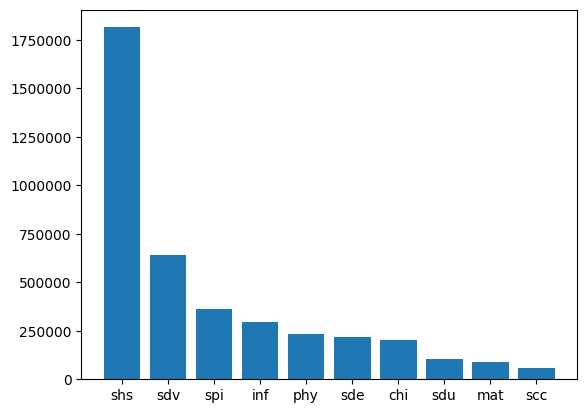

In [465]:
# URL3 = "https://api.archives-ouvertes.fr/search/?q=*%3A*&rows=0&wt=json&indent=true&facet=true&facet.field=domainAllCode_s&sort=docid asc"

# domains = jsonify(URL3)['facet_counts']['facet_fields']['domainAllCode_s']

# liDomains = domains[1::2]
# valDomains = domains[0::2]

# dom = dict(zip(valDomains,liDomains))

# # sort by value
# sorted_dict_val = dict(sorted(dom.items(), key=lambda item: item[1], reverse=True))

# sort by key
# dict(sorted(dom.items()))

# # writing it in a json file
# with open('disciplines.json', 'w') as json_file:
#    json.dump(sorted_dict_val, json_file)

# loading the json file
with open('disciplines.json', 'r') as json_file:
    disciplines = json.load(json_file)

sorted_dict_disciplines = sorted(disciplines.items())

print(dict(sorted_dict_disciplines))

totaux = {}
for key,value in sorted_dict_disciplines:
    prefixe = key[:3]
    totaux[prefixe] = totaux.get(prefixe,0) + value

totaux_sorted_value = dict(sorted(totaux.items(), key=lambda item: item[1], reverse=True))

x = totaux.keys()
y = totaux.values()

plt.bar(totaux_sorted_value.keys(),totaux_sorted_value.values())
plt.ticklabel_format(axis='y', style='plain')
plt.show()



#### Trying to create a tree out of HAL flat 393 domains and subdomains ("domainALLCode_s" field)

In [368]:
URL4 = "https://api.archives-ouvertes.fr/search/?q=docType_s:ART&rows=0&wt=json&indent=true&facet=true&facet.pivot=domainAllCode_s&facet.sort=count"

disciplineArt = jsonify(URL4)['facet_counts']['facet_pivot']['domainAllCode_s']

subdisciplines = {e['value']: e['count'] for e in disciplineArt if "." in e['value']}
globaldisciplines = {e['value']: e['count'] for e in disciplineArt if "." not in e['value']}

print(sum(subdisciplines.values()))
print(sum(globaldisciplines.values()))
# for e in disciplineArt:
#     if "." in e['value']:
#         print(e)
# for code_discipline, valeur in disciplineArt['value']

1360498
528101


#### Apache quiery to get the domain, doi, and type of a document

In [387]:
  field = "docType_s" # list of available fields https://api.archives-ouvertes.fr/docs/search/?schema=fields#fields 
  field_content = "ART"
  URL5 =  f"https://api.archives-ouvertes.fr/search/?q={field}:{field_content}&fl=label_s,doiId_s,domainAllCode_s,docType_s&rows=10&wt=json&indent=true"

  ressource_domains = jsonify(URL5)

  pprint(ressource_domains["response"]["docs"])

  xxx = 

[{'docType_s': 'ART',
  'domainAllCode_s': ['shs.art'],
  'label_s': 'Sylvie Aubenas. La panthéon Nadar.  Chroniques de la '
             'Bibliothèque nationale de France, 2014, 69, pp.29. '
             '&#x27E8;hal-04168965&#x27E9;'},
 {'docType_s': 'ART',
  'domainAllCode_s': ['shs.art'],
  'label_s': 'Sylvie Aubenas. Ken Jacobson, The Lovely Sea-View. A Study of '
             'the Marine Photographs published by Gustave Le Gray, 1856-1858, '
             'Petches Bridge, K. & J. Jacobson, 2001, 63 p., 18 ill. NB, 16 '
             'pl. bichr.. Etudes photographiques, 2002, mai. '
             '&#x27E8;hal-04168990&#x27E9;'},
 {'docType_s': 'ART',
  'domainAllCode_s': ['shs.art'],
  'label_s': 'Sylvie Aubenas. Clément Chéroux, Fautographie. Petite histoire '
             "de l'erreur photographique, Crisnée (Belgique), Yellow Now, "
             '2003, 192 p., ill. NB et coul.,19 €.. Etudes photographiques, '
             '2004. &#x27E8;hal-04168991&#x27E9;'},
 {'docType_s': 'ART'